In [2]:
import tensorflow as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt

### Utilities

In [3]:
def run_tf(x):
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config) as sess: 
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        out = sess.run(x)

        coord.request_stop()
        coord.join(threads)
        
        return out
    

class FLAGS(object):
    pass

FLAGS.batch_size = 128
FLAGS.data_dir = "/home/sankaran/exercise/ML/TF-Exercise/Tutorials/CIFAR/cifar-10-batches-bin"
FLAGS.num_preprocess_threads = 16
FLAGS.num_classes = 10
FLAGS.dtype = tf.float32

def distorted_inputs(data_dir, batch_size, distort=True):
    
    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i) for i in range(1, 6)]
    
    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames,seed=0)
    
    #Create FixedLenthRecord Reader with fixed bytes to read
    record_bytes = 32*32*3+1 #32*32*3 image with 1 byte for label
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    
    key, value = reader.read(filename_queue)
    
    ##Decode
    decoded = tf.decode_raw(value, tf.uint8)
    label = tf.strided_slice(decoded,[0],[1])
    image = tf.strided_slice(decoded,[1],[record_bytes])
    
    
    label = tf.cast(label,tf.int32)
    label = tf.reshape(label,[1])
    image = tf.reshape(image,[3,32,32])
    image = tf.transpose(image,[1,2,0])
    #image = tf.cast(image,tf.float32) ## DESTROYES IMAGE VIS
    
    ##PRE PROCESS
    if(distort):
        image = tf.random_crop(image, [24, 24, 3])
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image,max_delta=0.4)
        image = tf.image.random_contrast(image,lower=0.5,upper=1.8)
    
    image = tf.image.convert_image_dtype(image,dtype=FLAGS.dtype)
    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                             min_fraction_of_examples_in_queue)
    
    images, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        num_threads=FLAGS.num_preprocess_threads,
        capacity=min_queue_examples + 3 * batch_size,
        min_after_dequeue=min_queue_examples,
        seed=0)
    
    return [images,label_batch]

In [4]:
def inference(images):
    
    def weight_variable(shape,std=0.1,dtype=FLAGS.dtype):
      initializer = tf.truncated_normal_initializer(stddev=std, dtype=dtype)
      return tf.get_variable("Weights",shape,initializer=initializer,dtype=dtype)

    def bias_variable(shape,const=0.0,dtype=FLAGS.dtype):
      initializer = tf.constant_initializer(const,dtype)
      return tf.get_variable("biases",shape,initializer=initializer,dtype=dtype)
    
    print("input : ", images)
    
    with tf.variable_scope("conv1"):
        W_conv1 = weight_variable([5, 5, 3, 64])
        b_conv1 = bias_variable([64])

        conv = tf.nn.conv2d(images,W_conv1,strides=[1,1,1,1],padding="SAME")
        h_conv1 = tf.nn.relu(conv + b_conv1)
        
        print("conv 1 : ",h_conv1)
        
    with tf.variable_scope("maxpool1"):
        h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
        
        print("pool 1 : ",h_pool1)
        
    with tf.variable_scope("conv2"):
        W_conv2 = weight_variable([5, 5, 64, 64])
        b_conv2 = bias_variable([64])

        conv = tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding="SAME")
        h_conv2 = tf.nn.relu(conv + b_conv2)
        
        print("conv 2 : ",h_conv2)
        
    with tf.variable_scope("maxpool2"):
        h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")
        
        print("pool 2 : ",h_pool2)
        
    with tf.variable_scope("Flatten"):
        h_pool2_flat = tf.reshape(h_pool2, [FLAGS.batch_size, -1])
        
        print("flatten : ",h_pool2_flat)
        
    with tf.variable_scope("fc1"):
        W_fc1 = weight_variable([h_pool2_flat.shape[1].value, 384])
        b_fc1 = bias_variable([384])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
        print("fc1 : ",h_fc1)
        
    with tf.variable_scope("fc2"):
        W_fc2 = weight_variable([384, 192])
        b_fc2 = bias_variable([192])
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
        
        print("fc2 : ",h_fc2)
        
    with tf.variable_scope("logit"):
        W_fc3 = weight_variable([192, FLAGS.num_classes])
        b_fc3 = bias_variable([FLAGS.num_classes])
        logit = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
        
        print("logit : ",logit)
        
        return logit

In [5]:
with tf.variable_scope("Input-queue"):
    images,labels = distorted_inputs(FLAGS.data_dir,FLAGS.batch_size,distort=False)
    tf.summary.image('images', images)
    
logit = inference(images)
tf.summary.histogram("Logits",logit)

input :  Tensor("Input-queue/shuffle_batch:0", shape=(128, 32, 32, 3), dtype=float32)
conv 1 :  Tensor("conv1/Relu:0", shape=(128, 32, 32, 64), dtype=float32)
pool 1 :  Tensor("maxpool1/MaxPool:0", shape=(128, 16, 16, 64), dtype=float32)
conv 2 :  Tensor("conv2/Relu:0", shape=(128, 16, 16, 64), dtype=float32)
pool 2 :  Tensor("maxpool2/MaxPool:0", shape=(128, 8, 8, 64), dtype=float32)
flatten :  Tensor("Flatten/Reshape:0", shape=(128, 4096), dtype=float32)
fc1 :  Tensor("fc1/Relu:0", shape=(128, 384), dtype=float32)
fc2 :  Tensor("fc2/Relu:0", shape=(128, 192), dtype=float32)
logit :  Tensor("logit/Relu:0", shape=(128, 10), dtype=float32)


<tf.Tensor 'Logits:0' shape=() dtype=string>

In [6]:
out = run_tf(logit)
out.shape

(128, 10)

### Loss function

In [7]:
def loss(logit,lables):
    
    with tf.variable_scope("cross-entropy"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(labels,[FLAGS.batch_size]), logits=logit)
        avg_cross_entropy = tf.reduce_mean(cross_entropy)
        
        return avg_cross_entropy

### Training

**DECAYING LEARNING RATE**

**tf.train.exponential_decay**

Reduces learning rate exponentially every **decay_steps**

decayed_learning_rate = learning_rate X decay_rate ^ (global_step / decay_steps)


In [10]:
lr = tf.train.exponential_decay(learning_rate=0.01,global_step=10,decay_steps=100,decay_rate=0.1)
tf.Session().run(lr)

0.007943282

In [11]:
lr = tf.train.exponential_decay(0.01,100,100,0.1)
tf.Session().run(lr)

0.001

In [12]:
lr = tf.train.exponential_decay(0.01,200,100,0.1)
tf.Session().run(lr)

0.000100000005

In [16]:
e = []
for i in range(1000):
    e.append(tf.train.exponential_decay(0.1,i,400,0.01,staircase=True))
e_lr = tf.Session().run(e)

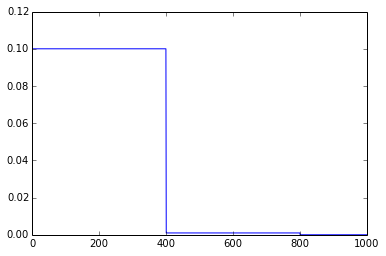

In [17]:
plt.plot(e_lr)

#### GRADIENT DESCENT

In [8]:
learning_rate = tf.placeholder(FLAGS.dtype)
decay_step = tf.placeholder(tf.int32)
decay_rate = tf.placeholder(FLAGS.dtype)
global_step = tf.train.get_or_create_global_step()

total_loss = loss(logit,labels)
tf.summary.scalar("mean_cross_entropy",total_loss)

<tf.Tensor 'mean_cross_entropy:0' shape=() dtype=string>

In [9]:
lr = tf.train.exponential_decay(
                                learning_rate=learning_rate,
                                global_step=global_step,
                                decay_steps=decay_step,
                                decay_rate=decay_rate,
                                staircase=True)
tf.summary.scalar("learning_rate",lr)
opt = tf.train.GradientDescentOptimizer(lr)
#opt = tf.train.AdamOptimizer(lr)
grads = opt.compute_gradients(total_loss)

grad_to_compute = [[g,v] for g,v in grads if g is not None]
# for grad,var in grad_to_compute:
#     tf.summary.histogram("Params/" + var.name,var)
#     tf.summary.histogram("Gradients/" + var.name,grad)
    
train_op = opt.apply_gradients(grads, global_step=global_step)

#### RUN SESSION

In [10]:
feed_dict = {learning_rate:0.01,
            decay_rate : 0.1,
            decay_step:80000}

max_steps = 1700

In [11]:
merged = tf.summary.merge_all()

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
with tf.Session(config=config) as sess: 
    
    writer = tf.summary.FileWriter("log/Train_random_init/t1_SGD_lr0.01",sess.graph)
    
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for i in range(max_steps):
        _,loss,out,summary = sess.run([train_op,total_loss,logit,merged],feed_dict=feed_dict)
        writer.add_summary(summary,i)
        if(i%100 == 0):
            print(i, "Loss : ", "{:.2e}".format(loss))

    coord.request_stop()
    coord.join(threads)

0 Loss :  5.75e+00
100 Loss :  2.21e+00
200 Loss :  2.21e+00
300 Loss :  2.18e+00
400 Loss :  2.24e+00
500 Loss :  2.23e+00
600 Loss :  2.24e+00
700 Loss :  2.13e+00
800 Loss :  2.21e+00
900 Loss :  2.22e+00
1000 Loss :  2.07e+00
1100 Loss :  1.99e+00
1200 Loss :  2.11e+00
1300 Loss :  2.13e+00
1400 Loss :  2.14e+00
1500 Loss :  2.16e+00
1600 Loss :  2.05e+00


In [13]:
run_tf(tf.train.get_global_step())

0

In [15]:
run_tf(tf.reshape(labels,[FLAGS.batch_size]))

array([4, 1, 3, 0, 1, 1, 7, 1, 9, 1, 4, 3, 1, 6, 5, 9, 1, 4, 0, 2, 5, 9,
       5, 6, 0, 5, 1, 1, 6, 2, 0, 2, 1, 5, 0, 4, 0, 7, 3, 0, 5, 6, 9, 2,
       5, 4, 9, 6, 6, 4, 3, 7, 0, 1, 0, 4, 3, 2, 7, 1, 5, 1, 2, 3, 8, 5,
       3, 5, 7, 2, 2, 4, 5, 5, 9, 4, 2, 2, 4, 8, 3, 8, 6, 9, 6, 9, 5, 2,
       1, 8, 7, 0, 1, 9, 1, 5, 4, 8, 5, 5, 3, 7, 1, 5, 2, 9, 3, 1, 5, 5,
       5, 0, 0, 3, 9, 5, 8, 6, 6, 6, 0, 7, 4, 3, 8, 9, 9, 5], dtype=int32)

In [11]:
grad_to_compute = [[g,v] for g,v in grads if g is not None]

In [15]:
for g,v in grad_to_compute:
    print(v.name)

conv1/Weights:0
conv1/biases:0
conv2/Weights:0
conv2/biases:0
fc1/Weights:0
fc1/biases:0
fc2/Weights:0
fc2/biases:0
logit/Weights:0
logit/biases:0
